# 4-1 核心元件
![3-1](https://github.com/hank199599/deep_learning_keras_log/blob/main/pictures/3-1.png?raw=true)  
* 層(layers)：組成一個神經網路模型
* 輸入資料(input data) 與 目標(target)：用來訓練及檢測一個神經網路
* 損失函數(loss functions)：取得學習的回饋信號
* 優化器(optimizer)：決定學習進行的方式

## 層(layers)
|向量資料|儲存的張量|使用的層|
|---|---|---|
|1D|2D|densely-connected layer 密集連接層
|2D|3D|recurrent layer 循環層
|3D|4D|Conv2D 2D卷積層  
  
須包含一層batch 維度，因此在儲存時的維度較訓練資料多一維

## 模型
神經網路拓樸定義了一個**假設空間(hypothesis space，只在該神經網路拓樸下權重參數所有可能的組態)**

## 損失函數 (loss function)
* 二元分類問題：二元交叉熵(binary crossentropy)
* 多類別分類問題：分類交叉熵(categorical crossentropy)
* 迴歸問題：均方差(meansquared error)
* 序列學習問題：連結時序問題(connectionist temporal classfication)


## GPU綁定
* cuda 11.3
* cudnn 8.1
* tensorflow 2.8 

In [1]:
from tensorflow.python.client import device_lib
import tensorflow as tf
local_device_protos = device_lib.list_local_devices()
for x in local_device_protos:
    if x.device_type=='GPU':
        print(x.physical_device_desc)
print(tf.config.list_physical_devices('GPU'))

device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 二元分類：電影評論為正評或負評
[IMDb,Internet Movie Database](https://www.imdb.com)

載入IMBD資料集

In [2]:
from tensorflow.keras.datasets import imdb

(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=10000)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
D:\anaconda\envs\mediapipe\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
D:\anaconda\envs\mediapipe\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If y

### num_words
表示讀取資料時，只允許「單字對應數字的字典」中編號0~9999的單字載入

In [3]:
max([max(sequence) for sequence in train_data])

9999

將數字還原成文字

In [4]:
word_index = imdb.get_word_index() #取得單字對應數字的字典
reverse_word_index = dict(
    [(value,key) for (key,value) in word_index.items()] #反轉為數字對應單字的字典
)

In [12]:
# word_index
counter=0
for key in reverse_word_index:
    if counter<=20:
        print(f'{key}-->{reverse_word_index[key]}')
    counter+=1

34701-->fawn
52006-->tsukino
52007-->nunnery
16816-->sonja
63951-->vani
1408-->woods
16115-->spiders
2345-->hanging
2289-->woody
52008-->trawling
52009-->hold's
11307-->comically
40830-->localized
30568-->disobeying
52010-->'royale
40831-->harpo's
52011-->canet
19313-->aileen
52012-->acurately
52013-->diplomat's
25242-->rickman


In [5]:
decord_review = ' '.join([reverse_word_index.get(i-3,'?') for i in train_data[0]])
decord_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## 準備資料
方法一：
1. 填補資料中每個子list的內容，使它們具有相同的長度
2. 在將整筆資料轉換成shape (樣本數、填補後的樣本長度)
3. 輸入到崁入層(Embedding layer)
  
方法二： 
1. 對資料中每個子list做[One-shot編碼](https://colab.research.google.com/github/hank199599/data_science_from_scratch_reading_log/blob/main/Chapter19.ipynb#scrollTo=QzUQbu-DtfQa)，將其轉換成由0與1組成的向量

```python
def one_hot_encode(i:int,num_labels:int=10)->List[float]:
  return [1.0 if j==i else 0.0 for j in range(num_labels)]
```
2. 輸入到可處理浮點數的密集層(Dense layer)


In [6]:
import numpy as np

def vectorize_sequences(sequences,dimension=10000):
    results = np.zeros((len(sequences),dimension))
    for i,sequences in enumerate(sequences):
        results[i,sequences] = 1.
    return results

### 將訓練資料轉換為維度為10000的向量

In [7]:
x_train = vectorize_sequences(train_data) # 將訓練資料向量化
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [8]:
x_test = vectorize_sequences(test_data)
x_test[0],test_data[0],x_test[0].shape,len(test_data[0]) 

(array([0., 1., 1., ..., 0., 0., 0.]),
 [1,
  591,
  202,
  14,
  31,
  6,
  717,
  10,
  10,
  2,
  2,
  5,
  4,
  360,
  7,
  4,
  177,
  5760,
  394,
  354,
  4,
  123,
  9,
  1035,
  1035,
  1035,
  10,
  10,
  13,
  92,
  124,
  89,
  488,
  7944,
  100,
  28,
  1668,
  14,
  31,
  23,
  27,
  7479,
  29,
  220,
  468,
  8,
  124,
  14,
  286,
  170,
  8,
  157,
  46,
  5,
  27,
  239,
  16,
  179,
  2,
  38,
  32,
  25,
  7944,
  451,
  202,
  14,
  6,
  717],
 (10000,),
 68)

In [9]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

### 將標籤資料向量化

In [10]:
y_train = np.array(train_labels).astype('float32')
y_train

array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [11]:
y_test = np.array(test_labels).astype('float32')

## 建立神經網路

### 建立密集層Dense堆疊結構，需確認的關鍵：
* 需要使用多少層?
* 每一層要有多少個神經元?

In [13]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
model = models.Sequential()
model.add(Dropout(0.2, input_shape=(10000,)))
model.add(layers.Dense(16,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))


編譯模型

In [14]:
model.compile(optimizer='adam',
       loss='binary_crossentropy', # 指定損失函數，並進行compile
       metrics=['accuracy'])

調整優化器

In [15]:
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=0.001), #調整優化器參數lr的值
       loss='binary_crossentropy',
       metrics=['accuracy'])

使用自行定義的損失函數與metrics函數

In [16]:
from tensorflow.keras import losses
from tensorflow.keras import metrics

model.compile(optimizer=optimizers.Adam(lr=0.001), #調整優化器參數lr的值
       loss=losses.binary_crossentropy, # 自行指定其他的損失函數與metrics函數
       metrics=[metrics.binary_accuracy])

## 設定驗證資料集  
從原始訓練資料中分離出10000樣本來建立驗證資料集

In [17]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## 訓練模型

In [18]:
model.compile(optimizer='adam', #調整優化器參數lr的值
       loss='binary_crossentropy', # 自行指定其他的損失函數與metrics函數
       metrics=['acc'])

history = model.fit(partial_x_train,
           partial_y_train,
           epochs=20,
           batch_size=512,
           validation_data=(x_val,y_val))

# model.fit()會回傳一個history的物件


Epoch 1/20
30/30 [==============================] - 6s 124ms/step - loss: 0.6214 - acc: 0.6700 - val_loss: 0.3901 - val_acc: 0.8575
Epoch 2/20
30/30 [==============================] - 1s 21ms/step - loss: 0.3304 - acc: 0.8853 - val_loss: 0.2921 - val_acc: 0.8878
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2259 - acc: 0.9181 - val_loss: 0.2758 - val_acc: 0.8919
Epoch 4/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1879 - acc: 0.9332 - val_loss: 0.2891 - val_acc: 0.8845
Epoch 5/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1617 - acc: 0.9392 - val_loss: 0.2899 - val_acc: 0.8854
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1397 - acc: 0.9494 - val_loss: 0.3023 - val_acc: 0.8826
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1245 - acc: 0.9551 - val_loss: 0.3152 - val_acc: 0.8828
Epoch 8/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1223 - 

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

繪製訓練與驗證的損失函數

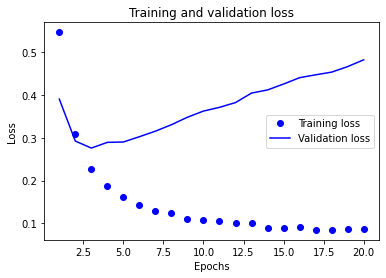

In [20]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(loss_values)+1)

plt.plot(epochs,loss_values,'bo',label='Training loss')
plt.plot(epochs,val_loss_values,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

繪製訓練與驗證的準確度

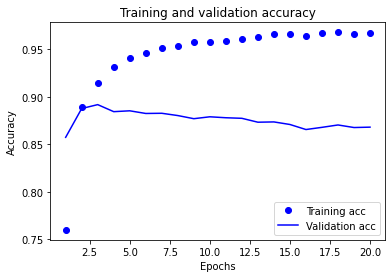

In [21]:
import matplotlib.pyplot as plt

plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

驗證準確度在第四個周期後，準確度就下降  
發生**過度適配(Overfitting)**

In [22]:
model.evaluate(x_test,y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.5226 - acc: 0.8536


[0.5226362347602844, 0.8535599708557129]

## 重新建立訓練模型
為了防止過度適配，將訓練週期限制在第四個周期後即結束訓練

In [23]:
from tensorflow.keras.layers import Dropout
model = models.Sequential()
model.add(Dropout(0.2, input_shape=(10000,)))
model.add(layers.Dense(16,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop', #調整優化器參數lr的值
       loss='binary_crossentropy', # 自行指定其他的損失函數與metrics函數
       metrics=['accuracy'])

model.fit(x_train,y_train,epochs=4,batch_size=512)
results=model.evaluate(x_test,y_test)

Epoch 1/4
49/49 [==============================] - 1s 12ms/step - loss: 0.5498 - accuracy: 0.7432
Epoch 2/4
49/49 [==============================] - 1s 12ms/step - loss: 0.2931 - accuracy: 0.8930
Epoch 3/4
49/49 [==============================] - 1s 11ms/step - loss: 0.2384 - accuracy: 0.9092
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.2831 - accuracy: 0.8874


In [24]:
results

[0.2830534279346466, 0.8873599767684937]

將準確度提升到88%準確度

## 使用神經網路對新資料進行預測

In [25]:
model.predict(x_test)

array([[0.26211566],
       [0.9996147 ],
       [0.9665518 ],
       ...,
       [0.16024373],
       [0.08001458],
       [0.4813676 ]], dtype=float32)

## 延伸實作

### 1. 使用一個隱藏層

In [26]:
model = models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop', #調整優化器參數lr的值
       loss='binary_crossentropy', # 自行指定其他的損失函數與metrics函數
       metrics=['accuracy'])

model.fit(x_train,y_train,epochs=4,batch_size=512)
results=model.evaluate(x_test,y_test)

Epoch 1/4
49/49 [==============================] - 3s 13ms/step - loss: 0.5149 - accuracy: 0.7624
Epoch 2/4
49/49 [==============================] - 0s 10ms/step - loss: 0.2703 - accuracy: 0.9106
Epoch 3/4
49/49 [==============================] - 0s 10ms/step - loss: 0.2084 - accuracy: 0.9312
Epoch 4/4
782/782 [==============================] - 1s 2ms/step - loss: 0.2835 - accuracy: 0.8859


### 2. 使用三個隱藏層

In [27]:
model = models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop', #調整優化器參數lr的值
       loss='binary_crossentropy', # 自行指定其他的損失函數與metrics函數
       metrics=['accuracy'])

model.fit(x_train,y_train,epochs=4,batch_size=512)
results=model.evaluate(x_test,y_test)

Epoch 1/4
49/49 [==============================] - 1s 14ms/step - loss: 0.5677 - accuracy: 0.7154
Epoch 2/4
49/49 [==============================] - 0s 10ms/step - loss: 0.2596 - accuracy: 0.9089
Epoch 3/4
49/49 [==============================] - 0s 10ms/step - loss: 0.1950 - accuracy: 0.9293
Epoch 4/4
782/782 [==============================] - 1s 2ms/step - loss: 0.3588 - accuracy: 0.8652


### 3. 使用32個單元

In [28]:
model = models.Sequential()
model.add(layers.Dense(128,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop', #調整優化器參數lr的值
       loss='binary_crossentropy', # 自行指定其他的損失函數與metrics函數
       metrics=['accuracy'])

model.fit(x_train,y_train,epochs=4,batch_size=512)
results=model.evaluate(x_test,y_test)

Epoch 1/4
49/49 [==============================] - 1s 14ms/step - loss: 0.5511 - accuracy: 0.6919
Epoch 2/4
49/49 [==============================] - 1s 10ms/step - loss: 0.2419 - accuracy: 0.9093
Epoch 3/4
49/49 [==============================] - 0s 10ms/step - loss: 0.1723 - accuracy: 0.9366
Epoch 4/4
782/782 [==============================] - 1s 2ms/step - loss: 0.3702 - accuracy: 0.8689


### 4. 使用64個單元

In [29]:
model = models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop', #調整優化器參數lr的值
       loss='binary_crossentropy', # 自行指定其他的損失函數與metrics函數
       metrics=['accuracy'])

model.fit(x_train,y_train,epochs=4,batch_size=512)
results=model.evaluate(x_test,y_test)

Epoch 1/4
49/49 [==============================] - 1s 15ms/step - loss: 0.5278 - accuracy: 0.7240
Epoch 2/4
49/49 [==============================] - 0s 10ms/step - loss: 0.2431 - accuracy: 0.9092
Epoch 3/4
49/49 [==============================] - 0s 10ms/step - loss: 0.1775 - accuracy: 0.9359
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.3813 - accuracy: 0.8645


### 5. 使用mse損失函數

In [30]:
model = models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop', #調整優化器參數lr的值
       loss='mse', # 自行指定其他的損失函數與metrics函數
       metrics=['accuracy'])

model.fit(x_train,y_train,epochs=4,batch_size=512)
results=model.evaluate(x_test,y_test)

Epoch 1/4
49/49 [==============================] - 1s 14ms/step - loss: 0.1917 - accuracy: 0.7413
Epoch 2/4
49/49 [==============================] - 1s 11ms/step - loss: 0.0877 - accuracy: 0.9085
Epoch 3/4
49/49 [==============================] - 1s 11ms/step - loss: 0.0626 - accuracy: 0.9294
Epoch 4/4
782/782 [==============================] - 1s 1ms/step - loss: 0.0856 - accuracy: 0.8852


### 6. 使用tanh啟動函數

In [31]:
model = models.Sequential()
model.add(layers.Dense(16,activation='tanh',input_shape=(10000,)))
model.add(layers.Dense(16,activation='tanh'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop', #調整優化器參數lr的值
       loss='binary_crossentropy', # 自行指定其他的損失函數與metrics函數
       metrics=['accuracy'])

model.fit(x_train,y_train,epochs=4,batch_size=512)
results=model.evaluate(x_test,y_test)

Epoch 1/4
49/49 [==============================] - 1s 14ms/step - loss: 0.5289 - accuracy: 0.7455
Epoch 2/4
49/49 [==============================] - 0s 10ms/step - loss: 0.2549 - accuracy: 0.9115
Epoch 3/4
49/49 [==============================] - 0s 10ms/step - loss: 0.1803 - accuracy: 0.9351
Epoch 4/4
782/782 [==============================] - 1s 2ms/step - loss: 0.3164 - accuracy: 0.8796


# 多元分類：數位新聞專欄
建構神經網路，將路透社的新聞專欄分成46個完全不同的主題  
**單標籤多類別分類(signal-label,multiclass classfication)**

載入路透社資料集

In [32]:
from tensorflow.keras.datasets import reuters

(train_data,train_labels),(test_data,test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 1s 0us/step


d:\anaconda\envs\mediapipe\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
d:\anaconda\envs\mediapipe\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [33]:
len(train_data)

8982

In [34]:
len(test_data)

2246

In [35]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

將數字還原成文字

In [36]:
word_index = reuters.get_word_index() #取得單字對應數字的字典
reverse_word_index = dict(
    [(value,key) for (key,value) in word_index.items()] #反轉為數字對應單字的字典
)

557056/550378 [==============================] - 0s 0us/step


In [37]:
decord_newseire = ' '.join([reverse_word_index.get(i-3,'?') for i in train_data[0]])
decord_newseire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [38]:
train_labels[10] #第10筆訓練資料的標籤為第3類

3

## 準備資料

In [39]:
import numpy as np

def vectorize_sequences(sequences,dimension=10000):
  results=np.zeros((len(sequences),dimension))
  for i,sequence in enumerate(sequences):
    results[i,sequence]=1.
  return results

### 將訓練資料轉換為維度為10000的向量

In [40]:
x_train = vectorize_sequences(train_data) # 將訓練資料向量化

In [41]:
x_test = vectorize_sequences(test_data)

## 對向量進行one-hot編碼

In [42]:
from tensorflow.keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## 建立神經網路
輸出空間的維度會大很多

In [44]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))

### 編譯模型

In [45]:
model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

## 驗證

In [46]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

進行訓練神經網路20個週期

In [47]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val,y_val))

Epoch 1/20
16/16 [==============================] - 2s 51ms/step - loss: 3.1206 - accuracy: 0.4226 - val_loss: 1.7260 - val_accuracy: 0.6460
Epoch 2/20
16/16 [==============================] - 0s 16ms/step - loss: 1.5048 - accuracy: 0.6971 - val_loss: 1.3143 - val_accuracy: 0.7180
Epoch 3/20
16/16 [==============================] - 0s 15ms/step - loss: 1.1194 - accuracy: 0.7592 - val_loss: 1.1738 - val_accuracy: 0.7400
Epoch 4/20
16/16 [==============================] - 0s 14ms/step - loss: 0.8757 - accuracy: 0.8120 - val_loss: 1.0527 - val_accuracy: 0.7850
Epoch 5/20
16/16 [==============================] - 0s 14ms/step - loss: 0.6879 - accuracy: 0.8582 - val_loss: 0.9839 - val_accuracy: 0.7960
Epoch 6/20
16/16 [==============================] - 0s 14ms/step - loss: 0.5682 - accuracy: 0.8816 - val_loss: 0.9475 - val_accuracy: 0.8010
Epoch 7/20
16/16 [==============================] - 0s 14ms/step - loss: 0.4416 - accuracy: 0.9128 - val_loss: 0.9305 - val_accuracy: 0.8030
Epoch 8/20
16

繪製訓練與驗證的損失函數

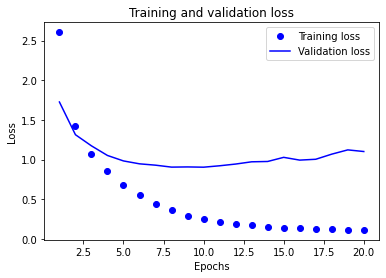

In [48]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

繪製訓練與驗證的準確度

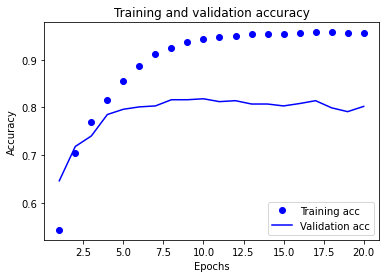

In [49]:
import matplotlib.pyplot as plt

plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

驗證準確度在第九個周期後，準確度就下降  
發生**過度適配(Overfitting)**

## 重新建立訓練模型
為了防止過度適配，將訓練週期限制在第四個周期後即結束訓練

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))

model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

model.fit(
    partial_x_train,
    partial_y_train,
    epochs=9,
    batch_size=512,
    validation_data=(x_val,y_val))
results=model.evaluate(x_test,one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 48ms/step - loss: 3.1010 - accuracy: 0.3698 - val_loss: 1.7667 - val_accuracy: 0.6360
Epoch 2/9
16/16 [==============================] - 1s 37ms/step - loss: 1.5206 - accuracy: 0.6930 - val_loss: 1.2999 - val_accuracy: 0.7330
Epoch 3/9
16/16 [==============================] - 1s 45ms/step - loss: 1.0736 - accuracy: 0.7777 - val_loss: 1.0981 - val_accuracy: 0.7650
Epoch 4/9
16/16 [==============================] - 1s 38ms/step - loss: 0.8162 - accuracy: 0.8248 - val_loss: 1.0119 - val_accuracy: 0.8000
Epoch 5/9
16/16 [==============================] - 1s 36ms/step - loss: 0.6469 - accuracy: 0.8665 - val_loss: 0.9416 - val_accuracy: 0.8070
Epoch 6/9
16/16 [==============================] - 1s 37ms/step - loss: 0.5121 - accuracy: 0.8987 - val_loss: 0.9278 - val_accuracy: 0.8020
Epoch 7/9
16/16 [==============================] - 1s 36ms/step - loss: 0.4121 - accuracy: 0.9197 - val_loss: 0.8979 - val_accuracy: 0.8160
Epoch 8/9
16/16 [===

In [ ]:
results

[1.0085341930389404, 0.7822796106338501]

將準確度提升到88%準確度

## 資料瓶頸
假定最終輸出有46個神經元，中間層應避免使用少於46神經元來傳遞資訊。 
避免資訊被壓縮。

## 延伸實作

### 1. 使用一個隱藏層

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(46,activation='softmax'))

model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

model.fit(
    partial_x_train,
    partial_y_train,
    epochs=9,
    batch_size=512,
    validation_data=(x_val,y_val))
results=model.evaluate(x_test,one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 48ms/step - loss: 3.0221 - accuracy: 0.4674 - val_loss: 1.7696 - val_accuracy: 0.6620
Epoch 2/9
16/16 [==============================] - 1s 38ms/step - loss: 1.5300 - accuracy: 0.7113 - val_loss: 1.3219 - val_accuracy: 0.7240
Epoch 3/9
16/16 [==============================] - 1s 37ms/step - loss: 1.0790 - accuracy: 0.7836 - val_loss: 1.1241 - val_accuracy: 0.7710
Epoch 4/9
16/16 [==============================] - 1s 38ms/step - loss: 0.8304 - accuracy: 0.8342 - val_loss: 1.0060 - val_accuracy: 0.7940
Epoch 5/9
16/16 [==============================] - 1s 36ms/step - loss: 0.6705 - accuracy: 0.8690 - val_loss: 0.9382 - val_accuracy: 0.8050
Epoch 6/9
16/16 [==============================] - 1s 38ms/step - loss: 0.5373 - accuracy: 0.8974 - val_loss: 0.8934 - val_accuracy: 0.8150
Epoch 7/9
16/16 [==============================] - 1s 37ms/step - loss: 0.4464 - accuracy: 0.9157 - val_loss: 0.8647 - val_accuracy: 0.8160
Epoch 8/9
16/16 [===

### 2. 使用三個隱藏層

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))

model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

model.fit(
    partial_x_train,
    partial_y_train,
    epochs=9,
    batch_size=512,
    validation_data=(x_val,y_val))
results=model.evaluate(x_test,one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 48ms/step - loss: 3.1435 - accuracy: 0.4162 - val_loss: 1.7653 - val_accuracy: 0.6310
Epoch 2/9
16/16 [==============================] - 1s 38ms/step - loss: 1.4881 - accuracy: 0.6965 - val_loss: 1.3421 - val_accuracy: 0.7140
Epoch 3/9
16/16 [==============================] - 1s 39ms/step - loss: 1.0851 - accuracy: 0.7710 - val_loss: 1.1444 - val_accuracy: 0.7680
Epoch 4/9
16/16 [==============================] - 1s 38ms/step - loss: 0.8491 - accuracy: 0.8236 - val_loss: 1.0467 - val_accuracy: 0.7890
Epoch 5/9
16/16 [==============================] - 1s 41ms/step - loss: 0.6695 - accuracy: 0.8584 - val_loss: 0.9854 - val_accuracy: 0.7890
Epoch 6/9
16/16 [==============================] - 1s 38ms/step - loss: 0.5403 - accuracy: 0.8869 - val_loss: 0.9531 - val_accuracy: 0.8160
Epoch 7/9
16/16 [==============================] - 1s 38ms/step - loss: 0.4276 - accuracy: 0.9124 - val_loss: 0.9139 - val_accuracy: 0.8150
Epoch 8/9
16/16 [===

### 3. 使用32個單元

In [ ]:
model = models.Sequential()
model.add(layers.Dense(32,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))

model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

model.fit(
    partial_x_train,
    partial_y_train,
    epochs=9,
    batch_size=512,
    validation_data=(x_val,y_val))
results=model.evaluate(x_test,one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 40ms/step - loss: 3.3485 - accuracy: 0.3252 - val_loss: 2.2853 - val_accuracy: 0.5800
Epoch 2/9
16/16 [==============================] - 0s 30ms/step - loss: 2.0021 - accuracy: 0.6265 - val_loss: 1.6580 - val_accuracy: 0.6510
Epoch 3/9
16/16 [==============================] - 1s 42ms/step - loss: 1.4701 - accuracy: 0.6967 - val_loss: 1.3805 - val_accuracy: 0.7050
Epoch 4/9
16/16 [==============================] - 1s 32ms/step - loss: 1.2098 - accuracy: 0.7474 - val_loss: 1.2428 - val_accuracy: 0.7250
Epoch 5/9
16/16 [==============================] - 0s 31ms/step - loss: 1.0231 - accuracy: 0.7813 - val_loss: 1.1491 - val_accuracy: 0.7520
Epoch 6/9
16/16 [==============================] - 1s 32ms/step - loss: 0.8722 - accuracy: 0.8200 - val_loss: 1.0913 - val_accuracy: 0.7620
Epoch 7/9
16/16 [==============================] - 0s 31ms/step - loss: 0.7546 - accuracy: 0.8428 - val_loss: 1.0513 - val_accuracy: 0.7810
Epoch 8/9
16/16 [===

### 4. 使用128個單元

In [ ]:
model = models.Sequential()
model.add(layers.Dense(128,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))

model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

model.fit(
    partial_x_train,
    partial_y_train,
    epochs=9,
    batch_size=512,
    validation_data=(x_val,y_val))
results=model.evaluate(x_test,one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 65ms/step - loss: 2.7893 - accuracy: 0.4535 - val_loss: 1.3531 - val_accuracy: 0.6980
Epoch 2/9
16/16 [==============================] - 1s 57ms/step - loss: 1.1454 - accuracy: 0.7578 - val_loss: 1.0936 - val_accuracy: 0.7630
Epoch 3/9
16/16 [==============================] - 1s 54ms/step - loss: 0.7825 - accuracy: 0.8333 - val_loss: 0.9593 - val_accuracy: 0.8050
Epoch 4/9
16/16 [==============================] - 1s 51ms/step - loss: 0.5486 - accuracy: 0.8816 - val_loss: 0.8798 - val_accuracy: 0.8200
Epoch 5/9
16/16 [==============================] - 1s 54ms/step - loss: 0.4040 - accuracy: 0.9146 - val_loss: 0.8472 - val_accuracy: 0.8170
Epoch 6/9
16/16 [==============================] - 1s 54ms/step - loss: 0.3024 - accuracy: 0.9317 - val_loss: 0.8754 - val_accuracy: 0.8130
Epoch 7/9
16/16 [==============================] - 1s 53ms/step - loss: 0.2360 - accuracy: 0.9469 - val_loss: 0.9095 - val_accuracy: 0.8020
Epoch 8/9
16/16 [===

# 迴歸：預測房價
預測連續值而不是離散標籤

## 準備資料
載入1970年代中期波士頓的郊區資料  
本例有506筆資料，分為404個訓練樣本和102個測試資料

In [ ]:
from keras.datasets import boston_housing

(train_data,train_targets),(test_data,test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [ ]:
train_data.shape

(404, 13)

In [ ]:
test_data.shape

(102, 13)

In [ ]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## 準備資料
對資料進行**正規化(normalization)**  
對每個特徵值減去平均值並減去標準差，簡化問題

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std 

## 建立神經網路
以單一unit結束且沒有啟動函數(代表將是線性層)

In [ ]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

## K-fold cross validation(K折交叉驗證)：驗證模型的成效
將可用資料拆分成K個區塊，保持模型不變的情況下：  
選一個區塊作為驗證集，而其餘區做當作訓練集。  
![pic3-2](https://github.com/hank199599/deep_learning_keras_log/blob/main/pictures/3-2.png?raw=true)  

**使資料集太小，使變異性增大的缺點平均掉。**

In [ ]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  #關掉TensorFlow的警告

k=4 # 進行4折交叉驗證
num_val_samples = len(train_data)//k
num_epochs=100
all_scores=[]

for i in range(k):
    print("process fold #",i)
    # 準備驗證資料，來自#k區塊
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]

    # 準備訓練資料，來自#k以外的區塊
    partical_train_data = np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)
    partical_train_targets = np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)  

    model = build_model()
    model.fit(partical_train_data,partical_train_targets,epochs=num_epochs,batch_size=1,verbose=0)

    val_mse,val_mae = model.evaluate(val_data,val_targets,verbose=0)
    all_scores.append(val_mae)

process fold # 0
process fold # 1
process fold # 2
process fold # 3


In [ ]:
all_scores

[2.5371220111846924, 2.5387237071990967, 2.766490936279297, 2.494704484939575]

In [ ]:
np.mean(all_scores)

2.5842602849006653

## 嘗試500 epochs來訓練

In [ ]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  #關掉TensorFlow的警告

k=4 # 進行4折交叉驗證
num_val_samples = len(train_data)//k
num_epochs=500
all_mae_history=[]

for i in range(k):
    print("process fold #",i)
    # 準備驗證資料，來自#k區塊
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]

    # 準備訓練資料，來自#k以外的區塊
    partical_train_data = np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)
    partical_train_targets = np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)  

    model = build_model()
    history = model.fit(partical_train_data,partical_train_targets,validation_data=(val_data,val_targets),epochs=num_epochs,batch_size=1,verbose=0)
    mae_history = history.history['val_mae']
    all_mae_history.append(mae_history)

process fold # 0
process fold # 1
process fold # 2
process fold # 3


建立平均K折驗證分數的歷史

In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_history]) for i in range(num_epochs)]

## 繪製驗證分數

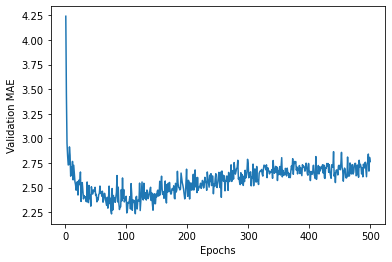

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 指數平均移動值
使現在的資料會被過去的資料所影響  
時間點越近的資料影響越大，越遠則越小


In [ ]:
def smooth_curve(points,factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

省略前10個資料點，並套用指數移動平均值

In [ ]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

### 圖3.13 每個訓練週期的驗證分數MAE，不包括前10個資料點

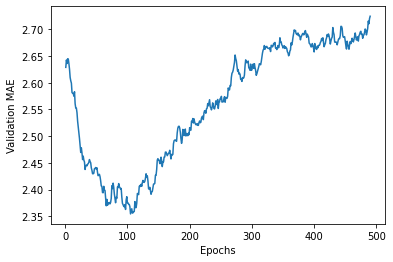

In [ ]:
plt.plot(range(1,len(smooth_mae_history)+1),smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

MAE在第80個週期後停止改善並開始往上升
發生過度適配的情形

## 訓練最終模型

In [ ]:
model = build_model()
model.fit(train_data,train_targets,epochs=80,batch_size=16,verbose=0)

test_mse_score,test_mae_score = model.evaluate(test_data,test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 17.7433 - mae: 2.6968


In [ ]:
test_mae_score

2.696845054626465

仍有$2,550美元左右的誤差